In [1]:
#!pip install torchsummary

# Version 3

## Target
Added GAP Layer

## Results

Parameters: 7,702


Best Train Accuracy: 99.29%

Best Test Accuracy : 99.24%


## Analysis
Accuracy got improved but didnt seem to overfit, and no. of parameters got reduced

# Importing Modules

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


# Data Transformations 

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Dataset and Creating Tarin/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders

In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Defining the Netwrok

In [6]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        # INPUT BLOCK
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(1, 8, 3, padding=0),         # (N, 1, 28, 28)  -> (N, 8, 26, 26) 
                                    nn.BatchNorm2d(8),
                                    nn.ReLU()
                                )
        
        # CONVOLUTION BLOCK 1
        self.conv2 = nn.Sequential(
                                    nn.Conv2d(8, 16, 3, padding=0),        # (N, 8, 26, 26) -> (N, 16, 24, 24)
                                    nn.BatchNorm2d(16),
                                    nn.ReLU()
                                )        
        
        # TRANSITION BLOCK 
        self.pool1 = nn.MaxPool2d(2, 2)                                    # (N, 16, 24, 24) -> (N, 16, 12, 12)        
        self.conv3 = nn.Sequential(
                                    nn.Conv2d(16, 8, 1, padding=0),        # (N, 16, 12, 12) -> (N, 8, 12, 12)
                                    nn.BatchNorm2d(8),
                                    nn.ReLU()
                                )

        # CONVOLUTION BLOCK 2
        self.conv4 = nn.Sequential(
                                    nn.Conv2d(8, 16, 3, padding=0),        # (N, 8, 12, 12) -> (N, 16, 10, 10)
                                    nn.BatchNorm2d(16),
                                    nn.ReLU()
                                 )
        
        # CONVOLUTION BLOCK 3
        self.conv5 = nn.Sequential(
                                    nn.Conv2d(16, 32, 3, padding=0),        # (N, 16, 10, 10)  -> (N, 32, 8, 8)
                                    nn.BatchNorm2d(32),
                                    nn.ReLU()
                                )

        self.conv6 = nn.Sequential(
                                    nn.Conv2d(32, 10, 1, padding=0),        # (N, 32, 8, 8)  -> (N, 10, 8, 8)
                                    nn.BatchNorm2d(10),
                                    nn.ReLU()
                                )        
        # OUTPUT LAYER
        self.gap = nn.Sequential(
                                    nn.AvgPool2d(kernel_size=8)
                                )

        self.dropout = nn.Dropout(0.10)
        
        
    def forward(self, x):
        x = self.conv1(x)
        
        x = self.conv2(x)
        x = self.pool1(x)        

        x = self.conv3(x)
        
        x = self.conv4(x)
        
        x = self.conv5(x)
        
        x = self.conv6(x)
        x = self.dropout(x)        
        
        x = self.gap(x)

        x = x.view(x.size(0), -1)
        x = F.log_softmax(x, dim=1)
        
        return x

# Model Parameters

In [7]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           1,168
       BatchNorm2d-5           [-1, 16, 24, 24]              32
              ReLU-6           [-1, 16, 24, 24]               0
         MaxPool2d-7           [-1, 16, 12, 12]               0
            Conv2d-8            [-1, 8, 12, 12]             136
       BatchNorm2d-9            [-1, 8, 12, 12]              16
             ReLU-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,168
      BatchNorm2d-12           [-1, 16, 10, 10]              32
             ReLU-13           [-1, 16, 10, 10]               0
           Conv2d-14             [-1, 3

# Training and Testing

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Start the Training

In [9]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.9)
EPOCHS = 15

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.14755728840827942 Batch_id=468 Accuracy=93.85: 100%|██████████| 469/469 [00:10<00:00, 45.90it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1251, Accuracy: 9611/10000 (96.11%)

EPOCH: 1


Loss=0.02682613581418991 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:10<00:00, 46.69it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1166, Accuracy: 9634/10000 (96.34%)

EPOCH: 2


Loss=0.12216305732727051 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:10<00:00, 46.27it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0504, Accuracy: 9846/10000 (98.46%)

EPOCH: 3


Loss=0.03810675069689751 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:10<00:00, 46.26it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0445, Accuracy: 9846/10000 (98.46%)

EPOCH: 4


Loss=0.07473131269216537 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:09<00:00, 47.13it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0490, Accuracy: 9854/10000 (98.54%)

EPOCH: 5


Loss=0.04191547632217407 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:09<00:00, 46.98it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0348, Accuracy: 9889/10000 (98.89%)

EPOCH: 6


Loss=0.009749486111104488 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:10<00:00, 45.83it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 9874/10000 (98.74%)

EPOCH: 7


Loss=0.018188323825597763 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:10<00:00, 46.29it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9899/10000 (98.99%)

EPOCH: 8


Loss=0.017992950975894928 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:10<00:00, 46.81it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9887/10000 (98.87%)

EPOCH: 9


Loss=0.04668465629220009 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:10<00:00, 46.66it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 9887/10000 (98.87%)

EPOCH: 10


Loss=0.02738596498966217 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:10<00:00, 45.80it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9907/10000 (99.07%)

EPOCH: 11


Loss=0.029906151816248894 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:10<00:00, 46.37it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9894/10000 (98.94%)

EPOCH: 12


Loss=0.16251184046268463 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:11<00:00, 42.62it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9904/10000 (99.04%)

EPOCH: 13


Loss=0.00497910613194108 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:10<00:00, 45.53it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9909/10000 (99.09%)

EPOCH: 14


Loss=0.05222734808921814 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:10<00:00, 45.61it/s]  



Test set: Average loss: 0.0255, Accuracy: 9924/10000 (99.24%)



# Plotting the graphs

Text(0.5, 1.0, 'Test Accuracy')

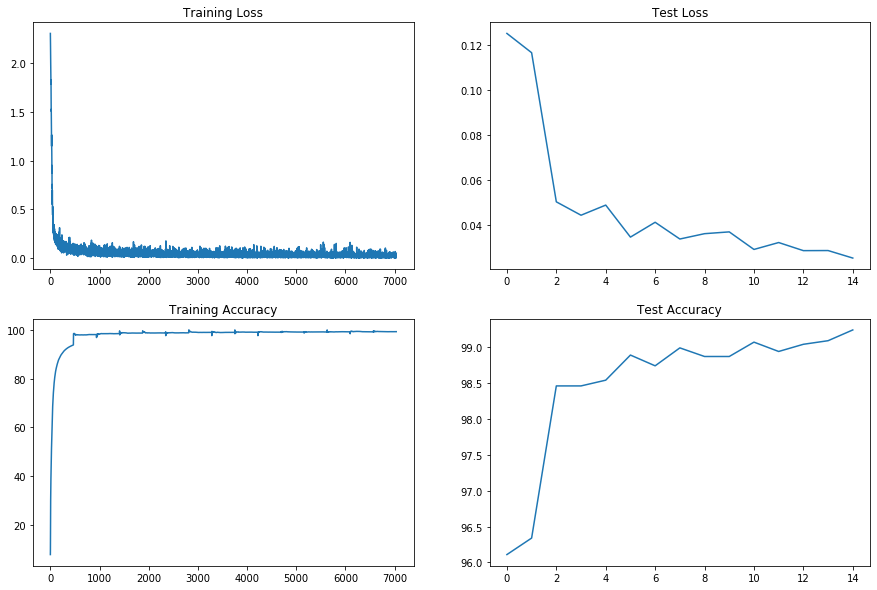

In [10]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")